# Interop with SketchUp Model

## 1. Basic Data Structure

There are two basic data structures for representing a 3D SketchUp model in the `tqec` library:

1. `ZXGraph`: ZX-calculus graph representation of the 3D model. Each spider represents a cube in the model and the Z/X type of the spider determines the color of the block.
2. `BlockGraph`: The explicit graph representation of a 3D model. The `Cube`s are the nodes in the graph and the edge represent the `Pipe` connecting two `Cube`s.

A `ZXGraph` can be converted to a `BlockGraph` by calling the `to_block_graph` method. The explicit block structures will be inferred from the `ZXGraph` and some validity checks will be performed. And a `BlockGraph` can be converted to a `ZXGraph` by calling the `to_zx_graph` method.

## 2. Examples

In [18]:
from pathlib import Path

import matplotlib.pyplot as plt

from tqec import Position3D, ZXGraph, BlockGraph, CubeType, PipeType

ASSETS_FOLDER = Path("../../assets/").resolve()

### 2.1 Import a SketchUp-exported `.dae` model as a `BlockGraph`

In [19]:
read_block_graph = BlockGraph.from_dae_file(
    ASSETS_FOLDER / "logical_cnot.dae", "Import Logical CNOT Block Graph"
)

### 2.2 Display the Collada model in IPython

By calling `display()` method, we can convert the `BlockGraph` to a Collada model and display the model in IPython compatible environments as embedded html with the help of `three.js`. Or we can save the visualization as a `.html` file and open it in a browser.

Function `display_collada_model` can also be used to display an arbitrary Collada model in IPython.

In [20]:
read_block_graph.display()

In [21]:
from tqec.computation.collada import display_collada_model

display_collada_model(
    ASSETS_FOLDER / "template.dae", write_html_filepath=ASSETS_FOLDER / "template.html"
)

### 2.3 Construct a logical CNOT with `ZXGraph`

Here we show how to construct a logical CNOT gate with `ZXGraph` and convert it to a `BlockGraph`:

In [22]:
logical_cnot_zx_graph = ZXGraph("Logical CNOT ZX Graph")

logical_cnot_zx_graph.add_z_node(Position3D(0, 0, 0))
logical_cnot_zx_graph.add_x_node(Position3D(0, 0, 1))
logical_cnot_zx_graph.add_z_node(Position3D(0, 0, 2))
logical_cnot_zx_graph.add_z_node(Position3D(0, 0, 3))
logical_cnot_zx_graph.add_x_node(Position3D(0, 1, 1))
logical_cnot_zx_graph.add_z_node(Position3D(0, 1, 2))
logical_cnot_zx_graph.add_z_node(Position3D(1, 1, 0))
logical_cnot_zx_graph.add_z_node(Position3D(1, 1, 1))
logical_cnot_zx_graph.add_z_node(Position3D(1, 1, 2))
logical_cnot_zx_graph.add_z_node(Position3D(1, 1, 3))


logical_cnot_zx_graph.add_edge(Position3D(0, 0, 0), Position3D(0, 0, 1))
logical_cnot_zx_graph.add_edge(Position3D(0, 0, 1), Position3D(0, 0, 2))
logical_cnot_zx_graph.add_edge(Position3D(0, 0, 2), Position3D(0, 0, 3))
logical_cnot_zx_graph.add_edge(Position3D(0, 0, 1), Position3D(0, 1, 1))
logical_cnot_zx_graph.add_edge(Position3D(0, 1, 1), Position3D(0, 1, 2))
logical_cnot_zx_graph.add_edge(Position3D(0, 1, 2), Position3D(1, 1, 2))
logical_cnot_zx_graph.add_edge(Position3D(1, 1, 0), Position3D(1, 1, 1))
logical_cnot_zx_graph.add_edge(Position3D(1, 1, 1), Position3D(1, 1, 2))
logical_cnot_zx_graph.add_edge(Position3D(1, 1, 2), Position3D(1, 1, 3))

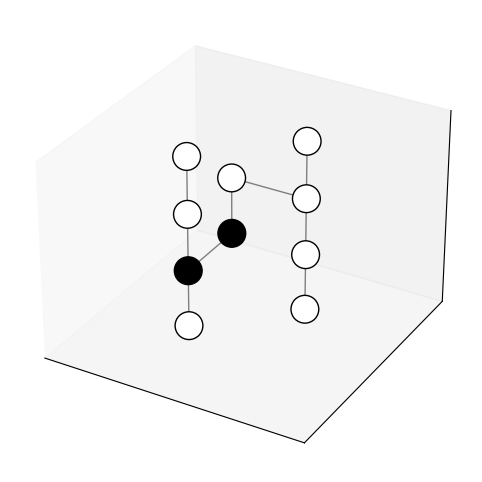

In [23]:
from tqec.computation.plot import draw_zx_graph_on

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
draw_zx_graph_on(logical_cnot_zx_graph, ax)

In [24]:
logical_cnot_block_graph = logical_cnot_zx_graph.to_block_graph(
    "Logical CNOT Block Graph"
)
logical_cnot_block_graph.display()

### 2.4 Construct a `BlockGraph` directly

Here we show how to construct a `BlockGraph` directly without using `ZXGraph`, then we save it to a `.dae` file.

In [26]:
four_way_junction_with_hadamards = BlockGraph("Four Way Junction with Hadamards")
four_way_junction_with_hadamards.add_cube(Position3D(0, 0, 0), CubeType.XXZ)
four_way_junction_with_hadamards.add_cube(Position3D(0, 1, 0), CubeType.VIRTUAL)
four_way_junction_with_hadamards.add_cube(Position3D(1, 0, 0), CubeType.VIRTUAL)
four_way_junction_with_hadamards.add_cube(Position3D(-1, 0, 0), CubeType.VIRTUAL)
four_way_junction_with_hadamards.add_cube(Position3D(0, -1, 0), CubeType.VIRTUAL)
four_way_junction_with_hadamards.add_pipe(Position3D(0, 0, 0), Position3D(0, 1, 0), PipeType.XOZH)
four_way_junction_with_hadamards.add_pipe(Position3D(0, 0, 0), Position3D(1, 0, 0), PipeType.OXZH)
four_way_junction_with_hadamards.add_pipe(Position3D(0, 0, 0), Position3D(-1, 0, 0), PipeType.OZXH)
four_way_junction_with_hadamards.add_pipe(Position3D(0, 0, 0), Position3D(0, -1, 0), PipeType.ZOXH)
four_way_junction_with_hadamards.display()

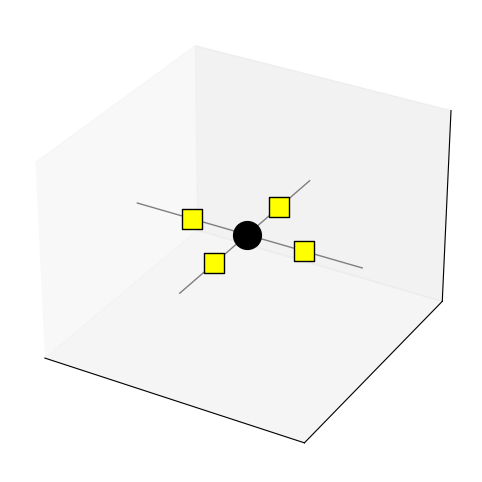

In [29]:
four_way_junction_with_hadamards_zx_graph = four_way_junction_with_hadamards.to_zx_graph(
    "Four Way Junction with Hadamards ZX Graph"
)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
draw_zx_graph_on(four_way_junction_with_hadamards_zx_graph, ax)

In [31]:
four_way_junction_with_hadamards.to_dae_file(
    "four_way_junction_with_hadamards.dae",
)